In [1]:
import numpy as np
import torchvision
from torchvision import transforms
import torch
from torch.utils.data import DataLoader, random_split

from numpy import genfromtxt
from low_altitude_nav.datasets.dataset import TerrainNavDataset
from imperative_learning.utils.esdf import ElevationMap
import open3d as o3d
import os
import sys
import matplotlib.pyplot as plt
import time
from IPython import display

%matplotlib widget

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
### Load TSDF Map
root_path = "/home/yixuany/Workspace/LowAltitudeFlight/deliverables/low_altitude_flight/terrain/tsdf_map"
map_name = "terrain_tsdf"
terrain_map = ElevationMap(device='cuda')
terrain_map.ReadTSDFMap(root_path, map_name)

In [3]:
device='cuda'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([256, 256])
])
expert_demo_dir = "/home/yixuany/Workspace/LowAltitudeFlight/deliverables/low_altitude_flight/expert_demonstrations/trajectories"
training_data_dir = "/home/yixuany/Workspace/LowAltitudeFlight/deliverables/low_altitude_flight/expert_demonstrations/images"
dataset = TerrainNavDataset(expert_demo_dir, training_data_dir, num_trajectories=1, transform=transform, preload=False, device=device)

Loading demonstrations: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

Number of data:  167
Finished creating dataset.


In [4]:
dataset.dataframe

,demonstration_id,timestep,rgb,rgb_tilted,depth,p_x,p_y,p_z,q_w,q_x,q_y,q_z,g_x,g_y,g_z,desired_trajectory,hx,hy,hz
0,0,0,/home/yixuany/Workspace/LowAltitudeFlight/deli...,/home/yixuany/Workspace/LowAltitudeFlight/deli...,/home/yixuany/Workspace/LowAltitudeFlight/deli...,-133.401786,-127.115031,18.81090,0.382888,0.0,0.0,-0.923795,-209.554786,-208.690031,2.72874,"[[-7.103340787007795, -7.368276971123464, -1.4...",-76.153,-81.5750,-16.08216
1,0,10,/home/yixuany/Workspace/LowAltitudeFlight/deli...,/home/yixuany/Workspace/LowAltitudeFlight/deli...,/home/yixuany/Workspace/LowAltitudeFlight/deli...,-134.442786,-128.194031,18.59160,0.391169,0.0,0.0,-0.920319,-209.588786,-210.190031,2.79790,"[[-7.062854291915613, -7.327233303143117, -1.4...",-75.146,-81.9960,-15.79370
2,0,20,/home/yixuany/Workspace/LowAltitudeFlight/deli...,/home/yixuany/Workspace/LowAltitudeFlight/deli...,/home/yixuany/Workspace/LowAltitudeFlight/deli...,-135.483786,-129.274031,18.37230,0.391169,0.0,0.0,-0.920319,-209.622786,-211.690031,2.86706,"[[-7.022834980098537, -7.285674787025357, -1.4...",-74.139,-82.4160,-15.50524
3,0,30,/home/yixuany/Workspace/LowAltitudeFlight/deli...,/home/yixuany/Workspace/LowAltitudeFlight/deli...,/home/yixuany/Workspace/LowAltitudeFlight/deli...,-136.524786,-130.354031,18.15300,0.391169,0.0,0.0,-0.920319,-209.657786,-213.189031,2.93622,"[[-7.261981377714619, -7.534019123011291, -1.5...",-73.133,-82.8350,-15.21678
4,0,40,/home/yixuany/Workspace/LowAltitudeFlight/deli...,/home/yixuany/Workspace/LowAltitudeFlight/deli...,/home/yixuany/Workspace/LowAltitudeFlight/deli...,-137.565786,-131.434031,17.93370,0.391169,0.0,0.0,-0.920319,-209.691786,-214.689031,3.00538,"[[-7.22036522870647, -7.490802352887442, -1.52...",-72.126,-83.2550,-14.92832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,0,1620,/home/yixuany/Workspace/LowAltitudeFlight/deli...,/home/yixuany/Workspace/LowAltitudeFlight/deli...,/home/yixuany/Workspace/LowAltitudeFlight/deli...,-261.161786,-316.100131,8.46067,0.640368,0.0,0.0,-0.768069,-265.829786,-341.627031,11.26890,"[[-2.334483832734861, -12.763361678829483, 1.4...",-4.668,-25.5269,2.80823
163,0,1630,/home/yixuany/Workspace/LowAltitudeFlight/deli...,/home/yixuany/Workspace/LowAltitudeFlight/deli...,/home/yixuany/Workspace/LowAltitudeFlight/deli...,-261.431786,-317.575731,8.62300,0.640368,0.0,0.0,-0.768069,-265.829786,-341.627031,11.26890,"[[-4.398000000000025, -24.051300000000026, 2.6...",-4.398,-24.0513,2.64590
164,0,1640,/home/yixuany/Workspace/LowAltitudeFlight/deli...,/home/yixuany/Workspace/LowAltitudeFlight/deli...,/home/yixuany/Workspace/LowAltitudeFlight/deli...,-261.701786,-319.051231,8.78533,0.640368,0.0,0.0,-0.768069,-265.829786,-341.627031,11.26890,"[[-4.128000000000043, -22.575800000000015, 2.4...",-4.128,-22.5758,2.48357
165,0,1650,/home/yixuany/Workspace/LowAltitudeFlight/deli...,/home/yixuany/Workspace/LowAltitudeFlight/deli...,/home/yixuany/Workspace/LowAltitudeFlight/deli...,-261.971786,-320.526831,8.94766,0.640368,0.0,0.0,-0.768069,-265.829786,-341.627031,11.26890,"[[-3.858000000000061, -21.10020000000003, 2.32...",-3.858,-21.1002,2.32124


In [5]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

Visualize interpolated expert trajectory in the dataset.

In [6]:
for idx, (features, labels) in enumerate(dataloader):
    rgb_img = features['rgb_img']
    rgb_tilted_img = features['rgb_tilted_img']
    heading = features['heading']
    attitude = features['attitude']
    position = features['position']

    desired_position = labels['desired_trajectory']

    current_position = position.squeeze(dim=0).cpu().numpy()
    heading = heading.squeeze(dim=0).cpu().numpy()
    planned_path_local = desired_position.squeeze(dim=0).cpu().numpy()
    planned_path_global = planned_path_local + current_position
    goal_position = 100.0*heading + current_position

    vis = [terrain_map.pcd_tsdf]
    point = o3d.geometry.TriangleMesh.create_sphere(radius=3.0, resolution=10)
    point.translate(goal_position - point.get_center())
    color = np.asarray([1.0, 0.0, 0.0])
    point.paint_uniform_color(color)
    vis.append(point)

    for i in range(len(planned_path_global)):
        point = o3d.geometry.TriangleMesh.create_sphere(radius=2.0, resolution=10)
        point.translate(planned_path_global[i, :3] - point.get_center())
        color = np.asarray([0.0, 1.0, 0.0])
        point.paint_uniform_color(color)
        vis.append(point)


    o3d.visualization.draw_geometries(vis)
    break


In [7]:
transform = transforms.Compose([
    transforms.Resize([256, 256])
])

Visualize the images.

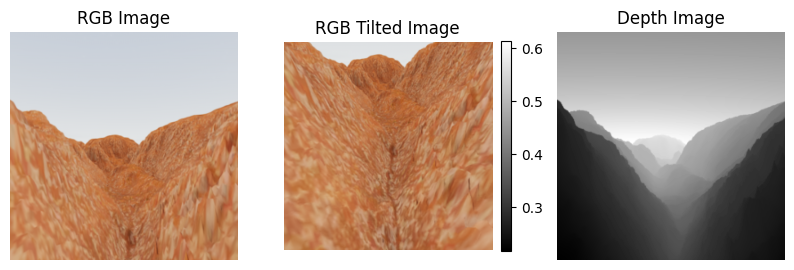

In [8]:
# Initialize the plot
fig, axes = plt.subplots(1, 3, figsize=(10, 6))
depth_img = dataset[0][1]['depth_img'].squeeze(dim=0).cpu().numpy()
rgb_img = transform(dataset[0][0]['rgb_img']).squeeze(dim=0).cpu().numpy().transpose(1, 2, 0)
rgb_tilted_img = transform(dataset[0][0]['rgb_tilted_img']).squeeze(dim=0).cpu().numpy().transpose(1, 2, 0)

# Display initial images
rgb_plot = axes[0].imshow(rgb_img)
axes[0].set_title("RGB Image")
axes[0].axis("off")

rgb_tilted_plot = axes[1].imshow(rgb_img)
axes[1].set_title("RGB Tilted Image")
axes[1].axis("off")


depth_plot = axes[2].imshow(depth_img, cmap='gray')
axes[2].set_title("Depth Image")
axes[2].axis("off")
cb = plt.colorbar(depth_plot, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

for i in range(0, 20):
    rgb_img = transform(dataset[i][0]['rgb_img']).squeeze(dim=0).cpu().numpy().transpose(1, 2, 0)
    depth_img = dataset[i][1]['depth_img'].squeeze(dim=0).cpu().numpy()
    rgb_tilted_img = transform(dataset[i][0]['rgb_tilted_img']).squeeze(dim=0).cpu().numpy().transpose(1, 2, 0)


    # Update image data
    rgb_plot.set_data(rgb_img)
    rgb_tilted_plot.set_data(rgb_tilted_img)
    depth_plot.set_data(depth_img)
    depth_plot.set_clim(vmin=np.min(depth_img), vmax=np.max(depth_img))  # Update color scale if needed

    # Update the canvas
    display.display(plt.gcf())
    display.clear_output(wait=True)  # Clear the previous output
    # display(fig)  # Display the updated figure

    time.sleep(0.001)  # Pause for visibility
plt.close()